In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense,GlobalAveragePooling2D, Input
from keras.optimizers import SGD, RMSprop, Adam
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from sklearn.utils.class_weight import compute_class_weight


from keras.callbacks import ModelCheckpoint, EarlyStopping

from time import time

import matplotlib.pyplot as plt

np.random.seed(617)

/home/danielchan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.visible_device_list = "0"
set_session(tf.Session(config=config))

In [3]:
def vgg16_model():
    from keras.applications.vgg16 import VGG16
    from keras.applications.vgg16 import preprocess_input
    img_width, img_height = 224,224
    print ('using the VGG16 model')
    input_shape=(img_width, img_height, 3)
    img_input = Input(shape=input_shape)
    base_model = VGG16(include_top=False, weights='imagenet', input_tensor=img_input)
    print('VGG16 model loaded')
    return base_model, img_width, img_height, preprocess_input

In [4]:
def resnet50_model():
    from keras.applications.resnet50 import ResNet50
    from keras.applications.resnet50 import preprocess_input
    img_width, img_height = 224,224
    print ('using the ResNet50 model')
    input_shape=(img_width, img_height, 3)
    img_input = Input(shape=input_shape)
    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=img_input)
    print('ResNet50 model loaded')
    return base_model, img_width, img_height, preprocess_input

Let find out which version of Keras we are running

In [5]:
import keras

print(keras.__version__)

2.2.0


In [6]:
def history_plot(history):

    %matplotlib inline

#_, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    fig, (ax1, ax2) = plt.subplots(1, 2)

    fig.tight_layout()
    ax1.grid(True)
    ax2.grid(True)
    ax1.plot(history.history['acc'])
    ax1.plot(history.history['val_acc'])
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'validation'], loc='best')

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'validation'], loc='best')

    plt.show()
    fig.savefig('history_VGG_fine_tune_plots.jpeg',dpi=600)

    return


In [7]:
def load_model(Top_load=False, Big_load=False):
# dimensions of our images.

   print (num_class)

   #num_class = 3
   #base_model, img_width, img_height, preprocess_input=resnet50_model()
   base_model, img_width, img_height, preprocess_input=vgg16_model()

# build a classifier model to put on top of the convolutional model

   top_model = Sequential()
   top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
   top_model.add(Dense(1024, activation='relu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=regularizers.l2(reg_fac)))
   top_model.add(BatchNormalization())
   top_model.add(Dense(num_class, activation='softmax'))
    
   # included a different style of constructing the top and base models for reference
   #x = base_model.output
   #x = Flatten()(x)
   #x = Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(reg_fac))(x)
   #x = BatchNormalization()(x)
   #top_layer = Dense(num_class, activation='softmax')(x)

   #top_model.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:]))
   #top_model.add(Dense(1024, activation='relu'))
   #top_model.add(BatchNormalization())
   #top_model.add(Dense(1024, activation='relu'))
   #top_model.add(BatchNormalization())
   #top_model.add(Dense(num_class, activation='softmax'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning

   if (Top_load):
        top_model.load_weights(Top_Model_Weights_File)
        print ("loaded the weights for top layers")
   

   #model = Model(inputs=base_model.input, outputs=top_layer)
   model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

   if (Big_load):
        model.load_weights(Full_Model_Weights_File)
        print ("loaded the weights for the entire model")
       

   return model,img_width, img_height,preprocess_input



In [8]:
from clr_callback import CyclicLR
from lr_finder import LRFinder
from sgdr import SGDRScheduler

In [9]:

def train_model(nb_batch=32,epochs=50,lr=1.e-5, 
                start_layer=15, Top_load=False, Big_load=False, CLR=True):

   nb_epoch = epochs
   batch_train = nb_batch
   batch_valid = nb_batch

   model,img_width,img_height,preprocess_input = load_model(Top_load=Top_load,
                                                            Big_load=Big_load)

   for layer in model.layers:
       layer.trainable = False

   for layer in model.layers[start_layer:]:
      layer.trainable = True

   for i, layer in enumerate(model.layers):
      print(i, layer.name, layer.trainable)


   model.compile(optimizer=SGD(lr=lr,momentum=0.8), loss='categorical_crossentropy', metrics=['accuracy']) 

   #train_data_dir='/home/danielchan/Downloads/Training_Data_Sq_orig'
   #validation_data_dir='/home/danielchan/Downloads/Test_Data_Sq_orig'

#define preprocessing function
#
#convert images from RGB to BGR so we can use the weights from Caffe simulation    

   datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
  

   train_generator = datagen.flow_from_directory(
            train_data_dir,
            target_size=(img_width, img_height),
            class_mode='categorical',
            batch_size=batch_train,
            shuffle=True)

   valid_generator = datagen.flow_from_directory(
            validation_data_dir,
            target_size=(img_width, img_height),
            class_mode='categorical',
            batch_size=batch_valid,
            shuffle=False)

   
   nb_train_samples = len(train_generator.classes)
   nb_validation_samples = len(valid_generator.classes)
    
   train_size = np.int( np.ceil(nb_train_samples/batch_train) )
   valid_size = np.int( np.ceil(nb_validation_samples/batch_valid) )

   print(nb_train_samples,nb_validation_samples,train_size,valid_size)



# checkpoint

   callbacks_list = []
    
   filepath="added_images_VGG16_weights.best"+".hdf5"
   checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                                save_best_only=True, mode='auto')
   callbacks_list.append(checkpoint)

   earlystop = EarlyStopping(monitor='val_acc', min_delta=0.1, patience=10, \
                          verbose=1, mode='auto')    
   #callbacks_list.append(earlystop) 
    
   clr = CyclicLR(base_lr=lower_lr, max_lr=upper_lr,
                       step_size=np.int(ncyle*np.ceil(nb_train_samples/batch_train)), 
                       mode='triangular')
   callbacks_list.append(clr) 

   wc = {0: 1.7825311942959001, 1: 0.4859086491739553, 2: 2.6246719160104988}
   wc = None
    
   history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_size,
        epochs=nb_epoch,
        verbose=2,
        validation_data=valid_generator,
        validation_steps=valid_size,callbacks=callbacks_list,
        class_weight=wc,
        workers=8, use_multiprocessing=True)


   #valid_generator.reset()
   #probs=model.predict_generator(valid_generator,verbose=1)
   
   return history,model


In [10]:
### beginning input parameters

Top_Model_Weights_File = "Sq_orig_added_images_top_model_weights_RES50"
Full_Model_Weights_File = "Sq_orig_added_images_full_model_weights_RES50"

Top_Model_Weights_File = "Sq_orig_added_images_top_model_weights_VGG16"
Full_Model_Weights_File = "Sq_orig_added_images_full_model_weights_VGG16_layer7"
Full_Model_Weights_File = "added_images_VGG16_weights.best.hdf5"
output_file = "Sq_orig_added_images_full_model_weights_VGG16_layers1"

train_data_dir='/home/danielchan/Downloads/Training_Data_Sq_orig_added_images'
validation_data_dir='/home/danielchan/Downloads/Test_Data_Sq_orig'
num_class = 3
lower_lr = 1.e-4
upper_lr = 1.e-3
ncyle = 8
reg_fac = 7e-4

### end of input parameters

start = time()
history,model=train_model(nb_batch=32,epochs=1,start_layer=1,Top_load=False, Big_load=True)
print ('time to train the model: ',time()-start)

model.save_weights(output_file) 


3
using the VGG16 model
VGG16 model loaded
loaded the weights for the entire model
0 input_1 False
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
19 sequential_1 True
Found 5000 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
5000 600 157 19
Epoch 1/1
 - 47s - loss: 1.2198 - acc: 1.0000 - val_loss: 2.7988 - val_acc: 0.7100

Epoch 00001: val_acc improved from -inf to 0.71000, saving model to added_images_VGG16_weights.best.hdf5
time to train the model:  49.159061670303345


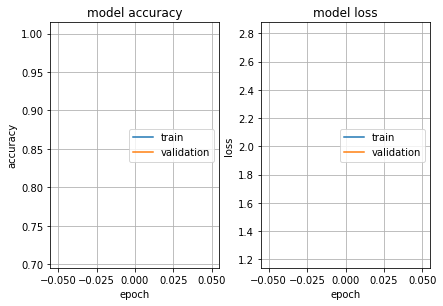

In [11]:
history_plot(history)

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [13]:
from keras.applications.vgg16 import preprocess_input

#validation_data_dir='/home/danielchan/Dropbox/ISIC2017/ISIC-2017_Test_Data'
batch = 128
img_width, img_height = 224,224

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_generator = datagen.flow_from_directory(
            validation_data_dir,
            target_size=(img_width, img_height),
            class_mode='categorical',
            batch_size=batch,
            shuffle=False)
steps = np.int(np.ceil(len(valid_generator.classes)/batch))
num_valid = len(valid_generator.classes)
print (num_valid,steps)

Found 600 images belonging to 3 classes.
600 5


In [14]:
probs = model.predict_generator(valid_generator, steps=steps, 
                                max_queue_size=10, workers=4, use_multiprocessing=True)


In [15]:
#validation_labels = np.argmax(labels[:,],axis=1)
validation_labels = valid_generator.classes

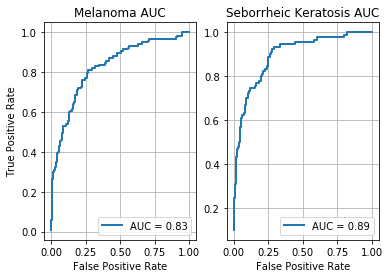

In [16]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(validation_labels, probs[:,0], 0)
roc_auc = auc(fpr, tpr)

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')
ax1.plot(fpr,tpr,linewidth=2.0,label='AUC = %0.2f' % roc_auc)
ax1.grid(True)
ax1.legend(loc="lower right")
ax1.set_title("Melanoma AUC")

fpr, tpr, thresholds = roc_curve(validation_labels, probs[:,2], 2)
roc_auc = auc(fpr, tpr)

ax2.set_xlabel('False Positive Rate')
ax2.plot(fpr,tpr,linewidth=2.0,label='AUC = %0.2f' % roc_auc)

ax2.grid(True)
ax2.legend(loc="lower right")
ax2.set_title("Seborrheic Keratosis AUC")
ax2.legend(loc="lower right")

plt.show()    

fig.savefig('VGG16_finetune_AUC_plots.jpeg',dpi=600)

In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix(validation_labels, np.argmax(probs[:,],axis=1))

array([[ 62,  37,  18],
       [ 42, 297,  54],
       [  7,  16,  67]])